<span style="font-size:16pt">
<p style="text-align: center;">
    МИНОБРНАУКИ РОССИИ <br>
    РГУ НЕФТИ И ГАЗА (НИУ) ИМЕНИ И.М. ГУБКИНА<br>
    ФАКУЛЬТЕТ АВТОМАТИКИ И ВЫЧИСЛИТЕЛЬНОЙ ТЕХНИКИ<br>
    КАФЕДРА АВТОМАТИЗИРОВАННЫХ СИСТЕМ УПРАВЛЕНИЯ<br>  <br>
    ДИСЦИПЛИНА <br>
        «Теория принятия решений. Нечеткие модели»
    <br><br> <br> <br> <br> <br> <br><br> <br> <br> <br> <br>
    ОТЧЁТ <br>
    по лабораторной работе №1 <br>
    «Нечеткая регрессия»<br> <br> <br> <br> <br>  <br><br>
    <br><br> <br> <br> <br> <br><br> <br> <br>
</p>

<p style="text-align: right;">
    Выполнил:<br>
    студент группы АС-21-05, Негробов В.А.<br>
    Проверил:<br>
    Манзюк Н.Ю.<br><br> <br> <br> <br> <br><br> <br> <br>
    <br><br> <br> <br> <br> <br><br> <br> <br>

<p style="text-align: center;">
    МОСКВА 2025
</p>
   </span>

# Библиотеки, используемые в работе:

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

# Метрики, используемые для оценки точности работы модели

In [8]:
def r2_score(y_true, y_pred):
    """
    Коэффициент детерминации
    Args:
       y_true (array-like): Истинные значения.
       y_pred (array-like): Предсказанные значения.
    Returns:
      float: Коэффициент детерминации.
    """
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return float(1 - (ss_res / ss_tot))

In [9]:
def mean_absolute_error(y_true, y_pred):
    """
    Средняя абсолютная ошибка
    Args:
       y_true (array-like): Истинные значения.
       y_pred (array-like): Предсказанные значения.
    Returns:
      float: Средняя абсолютная ошибка.
    """
    return np.mean(np.abs(y_true - y_pred))

In [10]:
def mean_squared_error(y_true, y_pred):
    """
    Средняя квадратичная ошибка
    Args:
       y_true (array-like): Истинные значения.
       y_pred (array-like): Предсказанные значения.
    Returns:
      float: Средняя квадратичная ошибка.
    """
    return np.mean((y_true - y_pred) ** 2)

# Генерация нечётких треугольных данных с шумами:

In [11]:
def generate_fuzzy_triangular_data(n_samples=50, a=2, b=30, noise_sigma=3, random_state=1):
    """
    Генерация нечётких треугольных данных с шумами.
    Args:
        n_samples (int): Количество образцов.
        a (float): Коэффициент наклона.
        b (float): Свободный член.
        noise_sigma (float): Стандартное отклонение шума.
        random_state (int): Зерно для генератора случайных чисел.
    Returns:
        X (array-like): Входные данные.
        y_central (array-like): Центральные значения нечётких данных.
        y_lower (array-like): Нижние значения нечётких данных.
        y_upper (array-like): Верхние значения нечётких данных.
    """
    np.random.seed(random_state) # Установка зерна для генерации псевдослучайных чисел
    X = np.random.uniform(1, 100, size=(n_samples, 1)) # Входные данные
    y_central = a * X.flatten() + b + np.random.normal(0, noise_sigma, n_samples) # Центральные значения
    y_upper = y_central + abs(np.random.normal(0, noise_sigma, n_samples)) # Верхние значения
    y_lower = y_central - abs(np.random.normal(0, noise_sigma, n_samples)) # Нижние значения
    return X, y_central, y_lower, y_upper


# Реализация нечеткой регрессии

В методе Танаки коэффициенты регрессии
представляются нечеткими числами. Цель – минимизировать размах
(неопределенность) модели.
Это делается путем оптимизации условий нечеткого покрытия данных
(чтобы предсказанные значения покрывали реальные наблюдения) и
минимизации ширины нечеткого коэффициента, чтобы неопределенность
модели была минимальной.
При этом основным недостатком метода является чувствительность к
выбросам в данных.

Классическая линейная регрессия имеет вид:

$𝑦 = 𝑤_0 + 𝑤_1𝑥 + 𝜀$,

где $𝑤_0$, $𝑤_1$ – параметры модели, 𝜀 – ошибка.

Параметры модели в нечеткой регрессии заменяются нечеткими
числами. В треугольном представлении:

$𝑤_𝑖 = (𝑤_{𝑖_𝑙}, 𝑤_{𝑖_𝑐}, 𝑤_{𝑖_𝑢})$.

При этом необходимо учитывать условие

$𝑚𝑖𝑛 ∑(𝑤_{𝑖_𝑙}^2 + 𝑤_{𝑖_𝑢}^2).$

В таких условиях выходное число также становится нечетким.

In [12]:
def tanaka_fuzzy_regression(X, y_lower, y_upper):
    X = np.hstack([np.ones((X.shape[0], 1)), X]) # Добавляем свободный член в матрицу X
    n_vars = X.shape[1]
    # Обычная регрессия для центральных коэффициентов
    beta_c = np.linalg.lstsq(X, (y_lower + y_upper) / 2, rcond=None)[0]
    # Вычисление ширины нечеткости
    c = np.hstack([np.zeros(n_vars), np.ones(n_vars)])
    A_ub = np.vstack([
        np.hstack([-X, -np.abs(X)]), # -beta_c - beta_w * x <= -y_lower
        np.hstack([X, -np.abs(X)]) # beta_c + beta_w * x >= y_upper
    ])
    b_ub = np.hstack([-y_lower, y_upper])

    # Решение задачи линейного программирования для ширины нечеткости
    result = opt.linprog(c, A_ub=A_ub, b_ub=b_ub, method="highs")
    if result.success:
        beta_w = result.x[n_vars:]
        return beta_c, beta_w
    else:
        raise ValueError("Оптимизация не удалась")

# Генерация данных и применение метода

In [13]:
# Генерация данных для нечеткой регрессии
X, y_central, y_lower, y_upper = generate_fuzzy_triangular_data()
# Применение метода Тананаки для вычиления коэффициентов нечеткой регрессии
beta_c, beta_w = tanaka_fuzzy_regression(X, y_lower, y_upper)
beta_c, beta_w

(array([30.17181237,  2.00408706]), array([0.       , 0.6174713]))

# Функция прогнозирования значений

In [14]:
def predict(X, beta_c, beta_w):
    """
    Функция для прогнозирования значений нечеткой регрессии.
    Args:
        X (np.ndarray): Входные данные.
        beta_c (np.ndarray): Коэффициенты центральной регрессии.
        beta_w (np.ndarray): Коэффициенты ширины нечеткости.
    Returns:
        y_pred_lower (np.ndarray): Нижняя граница прогнозирования.
        y_pred_central (np.ndarray): Центральное прогнозирование.
        y_pred_upper (np.ndarray): Верхняя граница прогнозирования.
    """
    # Добавляем столбец из единиц для свободного члена в линейной регрессии
    y_pred_central = np.hstack([np.ones((X.shape[0], 1)), X]) @ beta_c
    # Расчет верхней и нижней границ прогнозирования для нечеткости
    y_pred_upper = y_pred_central + np.hstack([np.ones((X.shape[0], 1)), X]) @ beta_w
    y_pred_lower = y_pred_central - np.hstack([np.ones((X.shape[0], 1)), X]) @ beta_w
    return y_pred_lower, y_pred_central, y_pred_upper
    

# Визуализация результатов

In [15]:
# Сортировка значений для построения графика
indexes = np.argsort(X, axis=0)[:, 0]
X_sorted = X[indexes]
y_central_sorted = y_central[indexes]
y_lower_sorted = y_lower[indexes]
y_upper_sorted = y_upper[indexes]

In [16]:
# Прогнозирование для отсортированных значений
y_pred_lower, y_pred_central, y_pred_upper = predict(X_sorted, beta_c, beta_w)

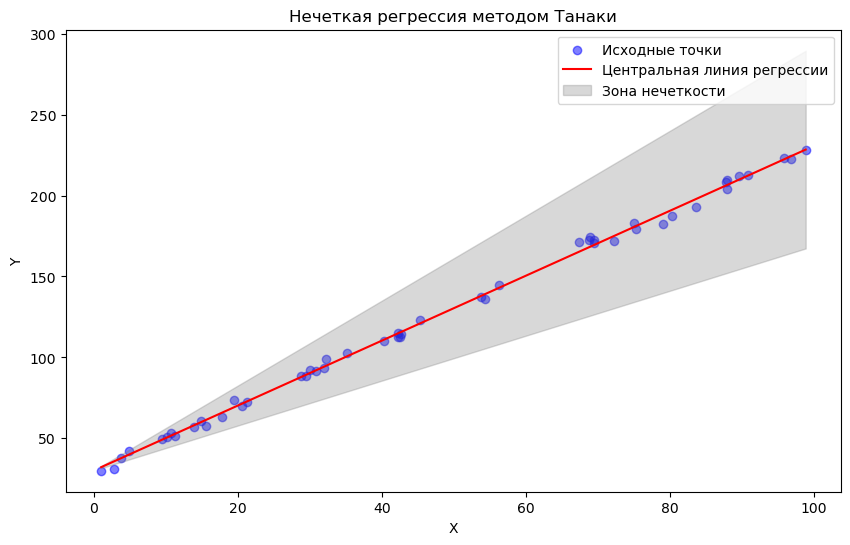

In [17]:
# Построение графика
plt.figure(figsize=(10, 6))
# Исходные точки с нечеткостью
plt.scatter(X, y_central, label='Исходные точки', color='blue', alpha=0.5)
# Центральные и граничные значения регрессии
plt.plot(X_sorted, y_pred_central, label='Центральная линия регрессии',
color='red')
plt.fill_between(X_sorted.flatten(), y_pred_lower, y_pred_upper, color='gray', alpha=0.3, label='Зона нечеткости')
# Настройка графика
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Нечеткая регрессия методом Танаки')
plt.show()

In [18]:
def calculate_and_print(y_central, y_lower, y_upper, y_pred_central, y_pred_lower, y_pred_upper, metric_function):
    """
   Вычисление и вывод метрики для центральных, верхних и нижних значений.
   Args:
   y_central (np.ndarray): Центральные значения истинных значений.
      y_lower (np.ndarray): Нижние значения истинных значений.
      y_upper (np.ndarray): Верхние значения истинных значений.
      y_pred_central (np.ndarray): Центральные значения прогнозируемых значений.
      y_pred_lower (np.ndarray): Нижние значения прогнозируемых значений.
      y_pred_upper (np.ndarray): Верхние значения прогнозируемых значений.
      metric_function (function): Функция метрики, которую нужно вычислить.
   Returns:
      None.
    """
    name = metric_function.__name__
    print(f"""
       {name} для центральных значений: {metric_function(y_central, y_pred_central)}
       {name} для верхних значений: {metric_function(y_upper, y_pred_upper)}
       {name} для нижних значений: {metric_function(y_lower, y_pred_lower)}
    """)

Коэффициент детерминации для
- центральных значений;
- верхних значений;
- нижних значений.

In [19]:
calculate_and_print(y_central_sorted, y_lower_sorted, y_upper_sorted, y_pred_central, y_pred_lower, y_pred_upper, r2_score)


       r2_score для центральных значений: 0.9980002963855361
       r2_score для верхних значений: 0.7074795140000969
       r2_score для нижних значений: 0.7026589768729654
    


Средняя абсолютная ошибка для
- центральных значений;
- верхних значений;
- нижних значений.

In [20]:
calculate_and_print(y_central_sorted, y_lower_sorted, y_upper_sorted, y_pred_central, y_pred_lower, y_pred_upper, mean_absolute_error)


       mean_absolute_error для центральных значений: 2.163563674443964
       mean_absolute_error для верхних значений: 27.106927500487316
       mean_absolute_error для нижних значений: 27.453511698480966
    


Средняя квадратичная ошибка для
- центральных значений;
- верхних значений;
- нижних значений.

In [21]:
calculate_and_print(y_central_sorted, y_lower_sorted, y_upper_sorted, y_pred_central, y_pred_lower, y_pred_upper, mean_squared_error)


       mean_squared_error для центральных значений: 7.381266103845884
       mean_squared_error для верхних значений: 1084.3891894240867
       mean_squared_error для нижних значений: 1085.7988293624237
    
